<h2>
Pairs Trading
</h2>
<p>
The Jupyter notebook explores pairs trading stratagies.
This document is available on the GitHub repository https://github.com/IanLKaplan/pairs_trading
</p>
<blockquote>
<p>
Pairs trading is an approach that takes advantage of the
mispricing between two (or more) co-moving assets, by
taking a long position in one (many) and shorting the
other(s), betting that the relationship will hold and that
prices will converge back to an equilibrium level.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> availabel from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading is sometimes referred to as a statistical arbitrage trading strategy.
</p>
<blockquote>
<p>
Statistical arbitrage and pairs trading tries to solve this problem using price relativity. If two assets share the same
characteristics and risk exposures, then we can assume that their behavior would be similar as well. This has
the benefit of not having to estimate the intrinsic value of an asset but rather just if it is under or overvalued
relative to a peer(s). We only have to focus on the relationship between the two, and if the spread happens
to widen, it could be that one of the securities is overpriced, the other is underpriced, or the mispricing is a
combination of both.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> availabel from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading algorithms have been reported to yield portfolios with Sharpe ratios in excess of 1.0 and returns of 10% or
higher. Pairs trading takes both long and short positions, so the portfolio tends to be market neutral. A pairs trading portfolio
can have drawdowns, but the drawdowns should be less than a benchmark like the S&P 500 because of the market neutral nature of the
portfolio.
</p>
<p>
Markets tend toward efficiency and many quantitative approaches fade over time as they are adopted by hedge funds. Pairs trading
goes back to the mid-1980s. Surprisingly, the approach still seems to be profitable. One reason for this could be that there are a vast
number of possible pairs and the pairs portfolio's tend to be fairly small (5 to 20 pairs, in most cases). This could
leave unexploited pairs in the market. Pairs trading may also be difficult to scale to a level that would be attractive to institutional
traders, like hedge funds, so the strategy has not been arbitraged out of the market.
</p>
<p>
Mathematical finance often uses models that are based on normal distributions, constant means and standard deviations. Actual market
data is often not normally distributed and changes constantly. The statistics used to select stocks for pairs trading makes an assumption
that the pair distribution has a constant mean and standard deviation. This assumption holds, at best, over a window of time.
</p>
<p>
The statistics that predict a successful pair will not be accurate in all time periods. For the strategy to be successful, the predicition
must be right more often than not. To minimize the risk in any particular trade, this suggests that trading a larger portfolio will
be more successful than trading a small portfolio.
</p>
<h3>
Overview
</h3>
<p>
The primary references used for this notebook are the books <i>Pairs Trading</i> by Ganapathy Vidyamurthy and <i>Algorithmic
Trading</i> by Ernest P. Chan.
</p>
<p>
The pairs trading strategy attempts to find a pair of stocks that, together, form a mean reverting time series.
</p>
<p>
Implementing the pairs trading strategy involves two logical steps:
</p>
<ol>
<li>
<p>
Pairs selection: Identify a pair of stocks that are likely to have mean reverting behavior using a lookback period.
</p>
</li>
<li>
<p>
Trading the stocks using the long/short strategy over the trading period. This involves building a trading signal
from the close prices of the stock pair. When the trading signal is above or below the mean at some threshold value
a long and short position are taken in the two stocks.
</p>
</li>
</ol>
<h2>
Pairs Selection
</h2>
<h3>
S&P 500 Industry Sectors
</h3>
<p>
Pairs are selected from the S&P 500 stock universe. These stocks are have a high trading volume, with a small bid-ask spread. These stocks
are also easier to short, with lower borrowing fees.
</p>
<p>
In pairs selection we are trying to find pairs that are cointegrated and have mean reverting behavior. The stock pairs should
have some logical connection. In the book <i>Pairs Trading</i> the author discusses using factor models to select pairs with
similar factor characteristics. A simpler approach is to select pairs from a common S&P 500 sector. This will tend to
select stocks with similar behavior, while reducing the universe of stocks from which pairs are selected.
</p>
<p>
Reducing the universe of stock pairs is important because, even with modern computing power, it would be difficult
to test all possible stock pairs in the S&P 500, since the number of pairs grows exponentially with N, the number of stocks.
</p>

\$ number \space of \space pairs = \frac{N^2 - N}{2} $

<p>
The S&P 500 component stocks (in 2022) and their related industries have been downloaded from barchart.com.  The files are included in this
GitHub repository.
</p>
<p>
The S&P 500 sectors are:
</p>
<ol>
<li>
Consumer discressionary
</li>
<li>
Consumer staples
</li>
<li>
Energy
</li>
<li>
Financials
</li>
<li>
Health care
</li>
<li>
Industrials
</li>
<li>
Info tech
</li>
<li>
Materials
</li>
<li>
Real estate
</li>
<li>
Communication services
</li>
<li>
Utilities
</li>
</ol>
<h3>
Stock Market Close Data
</h3>
<p>
The data used to model pairs trading in this notebook uses close price data for all of the S&P 500 stocks from the start date to yesterday
(e.g., one day in the past). In other models (see Stock Market Cash Trigger and ETF Rotation) the stock data was downloaded the first time the
notebook was run and stored in temporary files.  In these notebooks the first notebook run incurred the initial overhead of downloading
the data, but subsequent runs could read the data from local temporary files.
</p>
<p>
Downloading all of the close price data every day would have a high overhead for the S&P 500 stocks. To avoid this, the
data is downloaded once and stored in local files. When the notebook is run at later times, only the data between the
end of the last date in the file and the current end date will be downloaded.
</p>
<p>
There are stocks in the S&P 500 list that were listed on the stock exchange later than the start date.  These
stocks are filtered out, so the final stock set does not include all of the S&P 500 stocks.
</p>
<p>
Filtering stocks in this way can create a survivorship bias. This should not be a problem for back testing pairs trading
algorithms through the historical time period. The purpose of this backtest is to understand the pairs trading behavior.
The results do not depend on the stock universe, only on the pairs selected.
</p>


In [35]:
import os
from datetime import datetime
from multiprocessing import Pool
from typing import List, Tuple, Set

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy import log
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from plot_ts.plot_time_series import plot_ts, plot_two_ts
#
# Local libraries
#
from read_market_data.MarketData import MarketData
from utils.find_date_index import findDateIndex

# Apply the default theme
sns.set_theme()

s_and_p_file = 's_and_p_sector_components/sp_stocks.csv'
s_and_p_data = 's_and_p_data'
start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)

trading_days = 252


def read_s_and_p_stock_info(path: str) -> pd.DataFrame:
    """
    Read a file containing the information on S&P 500 stocks (e.g., the symbol, company name and sector)
    :param path: the path to the file
    :return: a DataFrame with columns Symbol, Name and Sector
    """
    s_and_p_stocks = pd.DataFrame()
    if os.access(path, os.R_OK):
        # s_and_p_socks columns are Symbol, Name and Sector
        s_and_p_stocks = pd.read_csv(s_and_p_file, index_col=0)
        new_names = [sym.replace('.', '-') for sym in s_and_p_stocks['Symbol']]
        s_and_p_stocks['Symbol'] = new_names
    else:
        print(f'Could not read file {s_and_p_file}')
    return s_and_p_stocks


def extract_sectors(stocks_df: pd.DataFrame) -> dict:
    """
    Columns in the DataFrame are Symbol,Name,Sector
    :param stocks_df:
    :return: a dictionary where the key is the sector and the value is a list of stock symbols in that sector.
    """
    sector: str = ''
    sector_l: list = list()
    stock_sectors = dict()
    for t, stock_info in stocks_df.iterrows():
        if sector != stock_info['Sector']:
            if len(sector_l) > 0:
                stock_sectors[sector] = sector_l
                sector_l = list()
            sector = stock_info['Sector']
        sector_l.append(stock_info['Symbol'])
    stock_sectors[sector] = sector_l
    return stock_sectors


def calc_pair_counts(sector_info: dict) -> pd.DataFrame:
    """
    Return a DataFrame
    :param sector_info: a dictionary where the key is the sector name and the
                        value is a list of stock symbols for that sector
    :return: a DataFrame where the index is the sector names and the columns are "num stocks" and "num pairs"
             "num stocks" is the number of stocks in the sector. "num pairs" is the number of unique pairs
             that can be formed from the set of sector stocks.  The last row is the sum of the columns.
    """
    column_label = ['num stocks', 'num pairs']
    sectors = list(sector_info.keys())
    counts_l: list = list()
    n_l: list = list()
    for sector in sectors:
        n = len(sector_info[sector])
        n_l.append(n)
        count = ((n ** 2.0) - n) / 2.0
        counts_l.append(count)
    num_stocks = sum(n_l)
    info_df = pd.DataFrame(n_l)
    info_df = pd.concat([info_df, pd.DataFrame(counts_l)], axis=1)
    info_df.columns = column_label
    sum_pairs = sum(counts_l)
    num_stocks_df = pd.DataFrame([num_stocks])
    sum_df = pd.DataFrame([sum_pairs])
    row_df = pd.concat([num_stocks_df, sum_df], axis=1)
    row_df.columns = column_label
    info_df = pd.concat([info_df, row_df], axis=0)
    sectors.append('Sum')
    info_df.index = sectors
    return info_df


# stock_info_df: a DataFrame with columns Symbol, Name, Sector
stock_info_df = read_s_and_p_stock_info(s_and_p_file)
stock_l: list = list(set(stock_info_df['Symbol']))
stock_l.sort()
market_data = MarketData(start_date=start_date, path=s_and_p_data)

# Get close prices for the S&P 500 list
close_prices_df = market_data.get_close_data(stock_l)
final_stock_list = list(close_prices_df.columns)
mask = stock_info_df['Symbol'].isin(final_stock_list)
# Some stocks were listed on the stock exchange later than start_date. In this case the stock will not
# be returned by MarketData.get_close_data(). final_stock_info has the Symbol, Name, Sector for the
# set of stocks that it was possible to obtain close prices for the date range.
final_stock_info_df = stock_info_df[mask]

sectors = extract_sectors(final_stock_info_df)
pairs_info_df = calc_pair_counts(sectors)


<p>
The table below shows the number of unique pairs for each S&P 500 sector and the total number of pairs. By drawing pairs from sectors,
rather than the whole S&P 500 set of stocks, the number of possible pairs is reduced from 124,750.
</p>

In [36]:
print(tabulate(pairs_info_df, headers=[*pairs_info_df.columns], tablefmt='fancy_grid'))

╒════════════════════════╤══════════════╤═════════════╕
│                        │   num stocks │   num pairs │
╞════════════════════════╪══════════════╪═════════════╡
│ information-technology │           55 │        1485 │
├────────────────────────┼──────────────┼─────────────┤
│ communication-services │           18 │         153 │
├────────────────────────┼──────────────┼─────────────┤
│ energies               │           16 │         120 │
├────────────────────────┼──────────────┼─────────────┤
│ utilities              │           25 │         300 │
├────────────────────────┼──────────────┼─────────────┤
│ real-estate            │           28 │         378 │
├────────────────────────┼──────────────┼─────────────┤
│ consumer-discretionary │           47 │        1081 │
├────────────────────────┼──────────────┼─────────────┤
│ financials             │           58 │        1653 │
├────────────────────────┼──────────────┼─────────────┤
│ industrials            │           58 │       

<h3>
Lookback Time Period
</h3>
<p>
Pairs are selected for trading using a lookback period. The longer the lookback period (with more data points) the
less error there will be in the selection statistics, assuming that the data is stable
(e.g., constant mean and standard deviation).  Stock price time series are not stable over time, however. The mean and the
standard deviation changes, as do other statistics like correlation and mean reversion.
</p>
<p>
In using a lookback period to choose trading pairs we are making the assumption that the past
will resemble the future trading period. The longer the lookback period, the less likely it is that the statistics will match
the trading period. This creates a tension between statistical accuracy and statistics that are more likely to reflect
the future trading period.
</p>
<p>
A half year period is used for the lookback period. In practice the statistics for a year period (252 trading days) and a
six month period (126 trading days) seem to be similar. We assume that the six month period will more accurately resemble the
future trading period.
</p>

<h2>
Correlation
</h2>
<p>
Stocks that are strongly correlated are more likely to also exhibit mean reversion since they have similar market behavior.
This section examines the correlation distribution for the S&P 500 sector pairs.
</p>
<p>
After selecting stocks based on their industry sector, the next filter used is the pair correlation of the
natural log of the close prices.
</p>


In [37]:

def get_pairs(sector_info: dict) -> List[Tuple]:
    """
    Return the sector stock pairs, where the pairs are selected from the S&P 500 sector.

    :param sector_info: A dictionary containing the sector info. For example:
                        energies': ['APA', 'BKR', 'COP', ...]
                       Here 'energies' is the dictionary key for the S&P 500 sector. The dictionary value is the
                       list of stocks in the sector.

    :return: A list of Tuples, where each tuple contains the symbols for the stock pair and the sector.
            For example:
              [('AAPL', 'ACN', 'information-technology'),
               ('AAPL', 'ADBE', 'information-technology'),
               ('AAPL', 'ADI', 'information-technology'),
               ('AAPL', 'ADP', 'information-technology'),
               ('AAPL', 'ADSK', 'information-technology')]
    """
    pairs_list = list()
    sectors = list(sector_info.keys())
    for sector in sectors:
        stocks = sector_info[sector]
        num_stocks = len(stocks)
        for i in range(num_stocks):
            stock_a = stocks[i]
            for j in range(i + 1, num_stocks):
                stock_b = stocks[j]
                pairs_list.append((stock_a, stock_b, sector))
    return pairs_list


def calc_pair_correlation(stock_close_df: pd.DataFrame, pair: Tuple, window: int) -> pd.Series:
    """
    Calculate the windowed correlations for a stock pair over the entire data set.
    :param stock_close_df: A data frame containing the stock close prices
    :param pair: the stock pair (e.g., a Tuple consisting of two strings for the stock symbols)
    :param window: The data window
    :return: a numpy array of windowed correlations for the pair over the entire time period.
    """
    window = int(window)
    cor_v = np.zeros(0)
    stock_a = pair[0]
    stock_b = pair[1]
    a_close = stock_close_df[stock_a]
    b_close = stock_close_df[stock_b]
    a_log_close = log(a_close)
    b_log_close = log(b_close)

    index = stock_close_df.index
    date_l: List = []
    assert len(a_log_close) == len(b_log_close)
    for i in range(0, len(a_log_close), window):
        sec_a = a_log_close[i:i + window]
        sec_b = b_log_close[i:i + window]
        c = np.corrcoef(sec_a, sec_b)
        cor_v = np.append(cor_v, c[0, 1])
        date_l.append(index[i])
    cor_s: pd.Series = pd.Series(cor_v)
    cor_s.index = date_l
    return cor_s


def calc_windowed_correlation(stock_close_df: pd.DataFrame, pairs_list: List[Tuple], window: int) -> np.array:
    """
    Calculate the windowed pair correlation over the entire time period, for all the pairs.

    :param stock_close_df: A data frame containing the stock close prices. The columns are the stock tickers.
    :param pairs_list: A list of the pairs formed from the S&P 500 sectors.
    :param window: the window over which the correlation is calculated.
    :return: A numpy array with the correlations.
    """
    window = int(window)
    all_cor_v = np.zeros(0)
    for pair in pairs_list:
        cor_v: np.array = calc_pair_correlation(stock_close_df, pair, window)
        all_cor_v = np.append(all_cor_v, cor_v)
    return all_cor_v


def display_histogram(data_v: np.array, x_label: str, y_label: str) -> None:
    num_bins = int(np.sqrt(data_v.shape[0])) * 4
    fix, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.hist(data_v, bins=num_bins, color="blue", ec="blue")
    plt.show()


lookback_window = int(trading_days / 2)
apple_tuple: Tuple = ('AAPL', 'MPWR')
apple_tuple_cor_s = calc_pair_correlation(stock_close_df=close_prices_df, pair=apple_tuple, window=lookback_window)


<p>
The lookback period for pairs selection is six months (126 trading days). As a first step, all of the S&P 500 sector
pairs will be tested for correlation over the lookback period.
</p>
<p>
Correlation is calculated on the log of the price for each stock pair.
</p>
<p>
The windowed correlation is not stable. The plot below shows the correlation between two stocks, AAPL and MPWR, over windowed
periods from the start date.
</p>

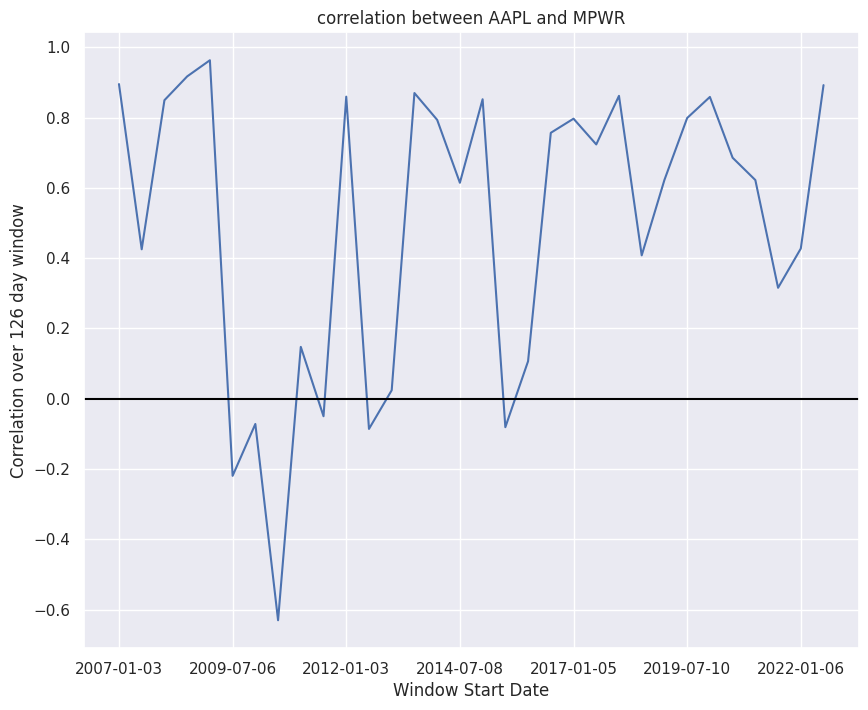

In [38]:

plot_ts(data_s=apple_tuple_cor_s, title=f'correlation between {apple_tuple[0]} and {apple_tuple[1]}',
        x_label='Window Start Date', y_label=f'Correlation over {lookback_window} day window')


<p>
Since correlation is not stable, a stock pair that is highly correlated in one time period be uncorrelated (or negatively
correlated) in another time period.
</p>
<p>
The histogram below shows the aggregate distribution of the pair correlation over all half year time periods.
</p>

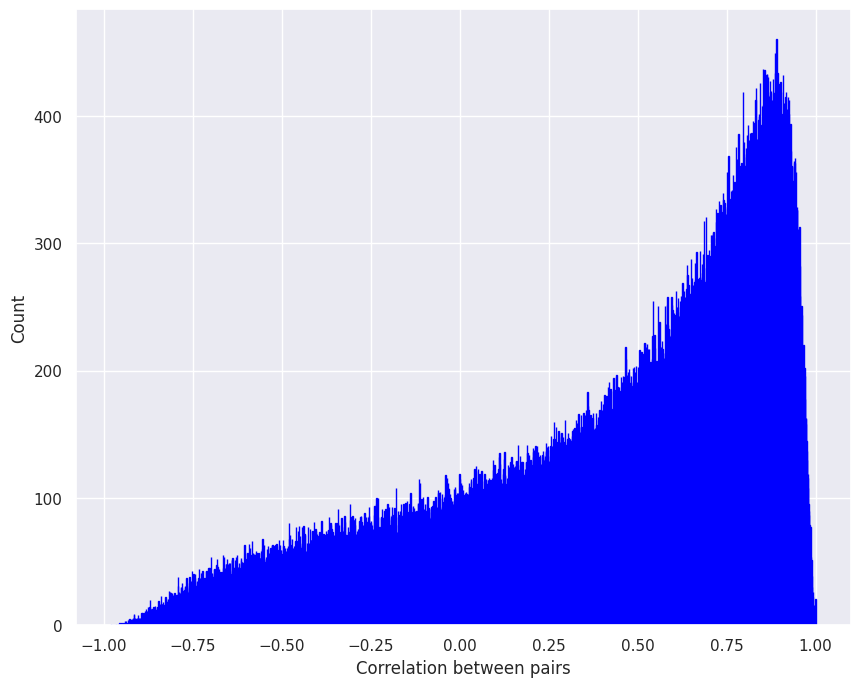

In [39]:

pairs_list = get_pairs(sectors)

cor_a = calc_windowed_correlation(close_prices_df, pairs_list, lookback_window)
display_histogram(cor_a, 'Correlation between pairs', 'Count')


<p>
There are a small number of pairs that have a strong negative correlation (a negative correlation -0.75 to approximately -0.9).
Initially we look at pairs that have a strong positive correlation, but it may be unwise to ignore the negative correlations as
well.
</p>

In [40]:
class WindowedCorrelationDist:

    def __init__(self,
                 stock_close_df: pd.DataFrame,
                 pairs_list: List[Tuple],
                 window: int,
                 cutoff: float):
        self.stock_close_df = stock_close_df
        self.window = window
        self.cutoff = cutoff
        self.pairs_list = pairs_list

    def window_correlation(self, start_ix: int) -> int:
        count = 0
        for pair in self.pairs_list:
            stock_a = pair[0]
            stock_b = pair[1]
            price_a = self.stock_close_df[stock_a].iloc[start_ix:start_ix + self.window]
            price_b = self.stock_close_df[stock_b].iloc[start_ix:start_ix + self.window]
            log_price_a = log(price_a)
            log_price_b = log(price_b)
            c = np.corrcoef(log_price_a, log_price_b)
            if c[0, 1] >= self.cutoff:
                count = count + 1
        return count

    def calc_correlation_dist(self) -> pd.Series:
        start_list = [ix for ix in range(0, self.stock_close_df.shape[0], self.window)]
        with Pool() as mp_pool:
            count_l = mp_pool.map(self.window_correlation, start_list)
        dist_s = pd.Series(count_l)
        index = self.stock_close_df.index
        dist_s.index = index[start_list]
        return dist_s

correlation_cutoff = 0.75
cor_dist_obj = WindowedCorrelationDist(stock_close_df=close_prices_df, pairs_list=pairs_list, window=lookback_window,
                                       cutoff=correlation_cutoff)
cor_dist = cor_dist_obj.calc_correlation_dist()

<p>
The plot below shows the number of pairs, in a half year time period period, with a correlation above a particular cutoff.
</p>

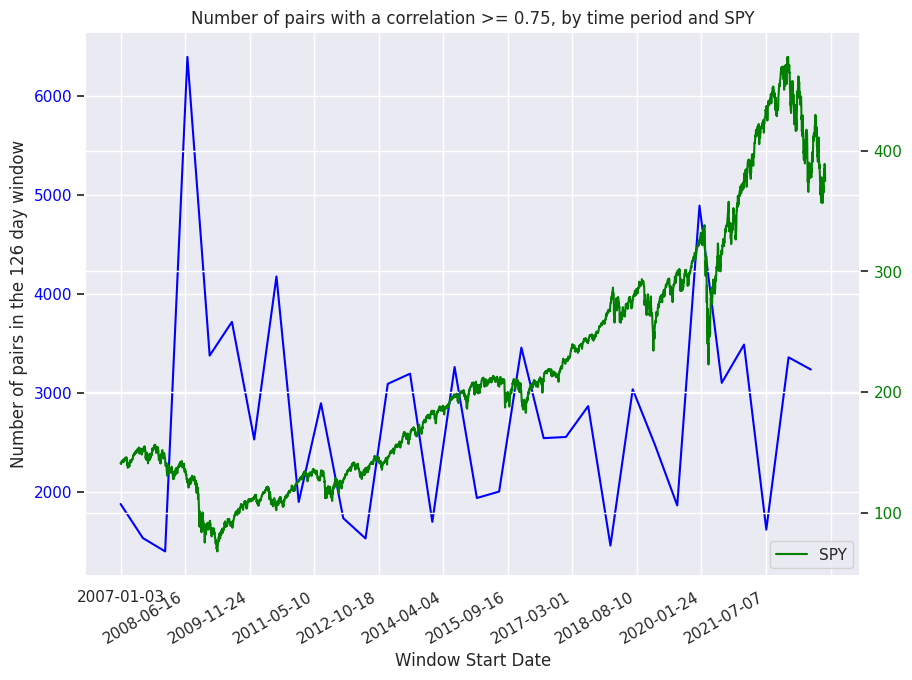

In [41]:

spy_close_df = market_data.read_data('SPY')
spy_close_s = spy_close_df[spy_close_df.columns[0]]
spy_close_s.columns = spy_close_df.columns
cor_dist.columns = ['Correlation']
plot_two_ts(data_a=cor_dist, data_b=spy_close_s, title=f"Number of pairs with a correlation >= {correlation_cutoff}, by time period and SPY",
        x_label='Window Start Date', y_label=f'Number of pairs in the {lookback_window} day window')

<p>
In the plot above, about 75% of the pairs are highly correlated around 2008. The corresponds to the 2008-2009 stock market crash
caused by the financial crisis. This lends validity to the financial market maxim that in a market crash, assets become correlated.
</p>
<p>
To the extent that correlation is a predictor for mean reversion, this also suggests that mean reversion statistics may be volatile.
</p>


<h3>
Linear Regression and Mean Reversion
</h3>
<p>
The plot below shows the linear regression between AAPL and MPWR in a period where they are highly correlated. The band in the regression
plot represents the 95% confidence interval for the regression line.
</p>

In [42]:
# log_pair_df = pd.concat([log_aapl_s, log_mpwr_s], axis=1)
#
# # https://seaborn.pydata.org/tutorial/regression.html
# s = sns.regplot(x=log_pair_df.columns[0], y=log_pair_df.columns[1], data=log_pair_df, scatter_kws={"color": "blue"},
#                 line_kws={"color": "red"})
# s.figure.set_size_inches(10, 6)
# s.set(title=f'Correlation {aapl_mpwr_cor}')
# plt.show()

<p>
The histogram below shows the number of pairs with a correlation greater than or equal to 0.75 in the first time period
(e.g., start_date to start_date + lookback_window).
</p>

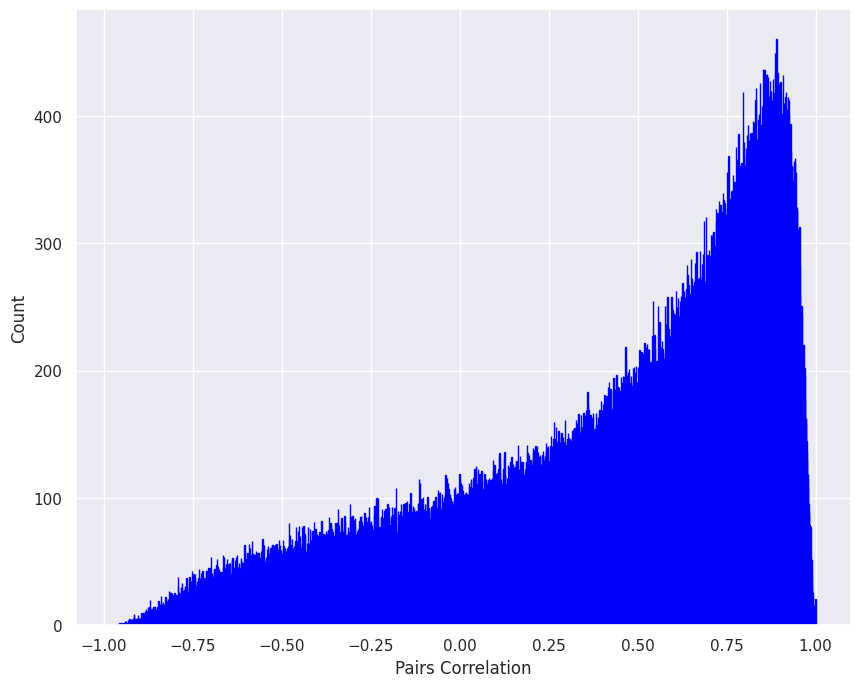

In [43]:

display_histogram(cor_a, 'Pairs Correlation', 'Count')


<h2>
Mean Reversion
</h2>
<p>
A single stock price series (or log price) is rarely stationary and mean reverting.
In selecting stock pairs we are looking for a stock pair that, when combined, is stationary and mean reverting. A stationary time series
is a time series that has a constant mean and standard deviation. Stock time series are constantly changing, so we are looking for
a pair that can form a stationary and mean reverting time series over a particular time window.
</p>
<p>
When a pair forms a mean reverting, stationary time series, it is referred to as a cointegrated time series.
</p>
<blockquote>
<p>
This (linear) price data combination of n different time series into one price data series is called cointegration and the resulting
price series w.r.t. financial data is called a cointegrated pair.
</p>
<p>
Cointegration Analysis of Financial Time Series Data by Johannes Steffen, Pascal Held and Rudolf Kruse, 2014
</p>
<p>
https://www.inf.ovgu.de/inf_media/downloads/forschung/technical_reports_und_preprints/2014/02_2014.pdf
</p>
</blockquote>
<p>
In the equation below, <i>m</i> is a stationary mean reverting time series, P<sub>A</sub> is the price series for stock A,
P<sub>B</sub> is the price series for stock B and β is the weight factor (for one share of stock A there will be β shares of
stock B).
</p>

\$  m = P_A - \beta P_B $

\$ m = \mu  \space when \space P_A = \beta P_B $

\$ m > \mu + \delta \space when \space P_A > \beta P_B \space (short \space P_A, \space long \space P_B) $

\$ m < \mu + \delta \space when \space P_A < \beta P_B \space (long \space P_A, \space sort \space P_B) $

<p>
When <i>m</i> is above the mean at some level (perhaps one standard deviation), a short position will be taken in stock A
and a long position will be taken in stock B.  When <i>m</i> is below the mean at some level (perhaps one standard deviation)
a long position will be taken in stock A and a short position will be taken in stock B. The position taken in stock B will be
larger than the postion in stock A by a factor of β.
</p>
<p>
In identifying a pair for pairs trading a determination is made on whether <i>m</i> is mean reverting.  The process of determining
mean reversion will also provide the value of β.
</p>
<h2>
Testing for Cointegration and Mean Reversion
</h2>
<p>
Pairs are selected from a common industry sector. This means that there is a good chance that the two stocks are affected by
similar market or economic dynamics. Once a pair with high correlation is identified, the next step is to test whether the
pair is cointegrated and mean reverting. Two tests are commonly used to test for mean reversion:
</p>
<ol>
<li>
Linear Regression and the Augmented Dickey Fuller (ADF) test (Engle-Granger test)
</li>
<li>
The Johansen Test
</li>
</ol>
<p>
Each of these tests has advantages and disadvantages, which will be discussed below.
</p>
<h3>
Linear Regression and the Augmented Dickey Fuller Test
</h3>
<p>
Two linear regressions are performed on the price series of the stock pair. The residuals of the regression with the highest
slope are tested with the Augmented Dickey Fuller (ADF) test to determine whether mean reversion is likely.
</p>
<p>
Linear regression is designed to provide a measure of the effect of a dependent variable (on the x-axis) to the independent
variable (on the y-axis).  An example might be the body mass index (a measure of body fat) on the x-axis to the blood cholesterol
on the y-axis.
</p>
<p>
In looking for stock pairs, we pick pairs that have relatively high correlation from a common industry sector, which means that some
process is acting on both stocks. However, the movement of one stock does not necessarily cause movement in the other stock. Also,
both stock price series tend to be driven by an underlying random process. This means that linear regression is not perfectly suited
for analyzing pairs. Two linear regressions are performed since we don't know which stock to pick for the dependent variable. The regression
with the highest slope is used to analyze mean reversion and build the cointegrated time series.
</p>
<p>
The result of the (Engle) Granger test is the weight value for the equation above, the linear regression intercept and
an estimate for the mean reversion confidence.
</p>

<h3>
The Johansen Test
</h3>
<p>
Unlike the Granger linear regression based test, the Johansen test can be used on more than two assets. The result is a multi-factor
linear model for the cointegration mean reverting time series. This notebook focuses on pairs, so this is a feature of
the Johansen test that is not exploited.
</p>
<p>
The Johansen test uses eigenvalue decomposition for the estimation of cointegration. The Granger test has two steps: linear regression
and the ADF test. The Johansen test is a single test that also provides the weight factor. There is no linear constant (regression intercept)
as there is with the Granger test.
</p>

In [44]:
class CointData:
    """
    cointegrated: boolean - true if the time series were cointegrated, false otherwise
    weight: float - in the stationary cointegrtion equation x = A - w * B
    confidence: int - confidence level, in percent: 90, 95, 99
    asset_a: str - the symbol for the time series A in the above equation
    asset_b: str - the symbol for the time series B in the above equation
    """
    def __init__(self,
                 cointegrated: bool,
                 confidence: int,
                 weight: float,
                 asset_a: str,
                 asset_b: str):
        self.cointegrated = cointegrated
        self.confidence = confidence
        self.weight = weight
        self.asset_a = asset_a
        self.asset_b = asset_b
        self.intercept = np.NAN


    def __str__(self):
        if self.has_intercept():
            s = f'cointegrated: {self.cointegrated}, confidence: {self.confidence}, weight: {self.weight}, intercept: {self.get_intercept()} ({self.asset_a}, {self.asset_b})'
        else:
            s = f'cointegrated: {self.cointegrated}, confidence: {self.confidence}, weight: {self.weight}, ({self.asset_a}, {self.asset_b})'
        return s

    def set_intercept(self, intercept: float) -> None:
        self.intercept = intercept

    def get_intercept(self) -> float:
        return self.intercept

    def has_intercept(self) -> bool:
        return not np.isnan(self.intercept)


class PairStatistics:
    def __init__(self):
        self.decimals = 2
        pass

    def correlation(self, data_a: pd.DataFrame, data_b: pd.DataFrame) -> float:
        c = np.corrcoef(data_a, data_b)
        cor_v = round(c[0, 1], 2)
        return cor_v

    def find_interval(self, coint_stat: float, critical_vals: dict) -> Tuple[bool, int]:
        """
        :param coint_stat: the ADF statistic
        :param critical_vals: a dictionary defining the ADF intervals {'1%': -3.49, '5%': -2.89, '10%': -2.58}. The
                              dictionary values may be either positive or negative.
        :return: if the adf_stat is in the critical value range, return True and the integer value of the interval
                 (e.g., 1, 5, 10). Or False and 0
        """
        cointegrated = False
        interval_key = ''
        interval = 0
        abs_coint_stat = abs(coint_stat)
        for key, value in critical_vals.items():
            abs_value = abs(value)
            if abs_coint_stat > abs_value and abs_value > interval:
                interval = abs_value
                interval_key = key
                cointegrated = True
        key_val = int(interval_key.replace('%','')) if cointegrated else 0
        return cointegrated, key_val


    def engle_granger_coint(self, data_a: pd.DataFrame, data_b: pd.DataFrame) -> CointData:
        sym_a = data_a.columns[0]
        sym_b = data_b.columns[0]
        data_b_const = sm.add_constant(data_b)
        # x = I + b * A
        result_ab = sm.OLS(data_a, data_b_const).fit()
        data_a_const = sm.add_constant(data_a)
        # x = I + b * B
        result_ba = sm.OLS(data_b, data_a_const).fit()
        slope_ab = result_ab.params[data_b.columns[0]]
        slope_ba = result_ba.params[data_a.columns[0]]
        result = result_ab
        slope = slope_ab
        if slope_ab < slope_ba:
            t = sym_a
            sym_a = sym_b
            sym_b = t
            result = result_ba
            slope = slope_ba
        intercept = round(result.params['const'], self.decimals)
        slope = round(slope, self.decimals)
        residuals = result.resid
        adf_result = adfuller(residuals)
        adf_stat = round(adf_result[0], self.decimals)
        critical_vals = adf_result[4]
        cointegrated, interval = self.find_interval(adf_stat, critical_vals)
        coint_data = CointData(cointegrated=cointegrated, confidence=interval, weight=slope, asset_a=sym_a, asset_b=sym_b)
        coint_data.set_intercept(intercept=intercept)
        return coint_data

    def johansen_coint(self, data_a: pd.DataFrame, data_b: pd.DataFrame) -> CointData:
        ts_df = pd.concat([data_a, data_b], axis=1)
        johansen_rslt_ab = coint_johansen(ts_df, 0, 1)
        hedge_ab_val = np.abs(johansen_rslt_ab.evec[0, 0] / johansen_rslt_ab.evec[1, 0])
        hedge_ab = pd.DataFrame([hedge_ab_val])
        hedge_ab.columns = [data_a.columns[0]]
        critical_vals_ab = pd.DataFrame(johansen_rslt_ab.trace_stat_crit_vals[0]).transpose()
        critical_vals_ab.columns = ['10%', '5%', '1%']
        critical_vals_dict = critical_vals_ab.to_dict('records')[0]
        trace_stat_ab = johansen_rslt_ab.trace_stat[0]
        cointegrated, interval = self.find_interval(coint_stat=trace_stat_ab, critical_vals=critical_vals_dict)
        sym_a = data_a.columns[0]
        sym_b = data_b.columns[0]
        coint_data = CointData(cointegrated=cointegrated, confidence=interval, weight=hedge_ab, asset_a=sym_a,
                               asset_b=sym_b)
        return coint_data

    def compute_halflife(self, z_df: pd.DataFrame) -> int:
        """
        Calculate the half-life of a mean reverting stationary series where the series
        is an Ornstein–Uhlenbeck process
        From example 7.5 in Quantitative Trading by Ernest P. Chan
        """
        prevz = z_df.shift()
        dz = z_df - prevz
        dz = dz[1:]
        prevz = prevz[1:]
        result = sm.OLS(dz, prevz - np.mean(prevz)).fit()
        theta = result.params
        halflife_f = -np.log(2) / theta
        halflife = round(halflife_f, 0)
        return halflife

    def stationary_series(self, data_a: pd.DataFrame, data_b: pd.DataFrame, coint_data: CointData) -> np.ndarray:
        """
        compute the stationary time series x = A - w * B  or x = A - i - w * B if there is an intercept i
        """
        if coint_data.has_intercept():
            stationary_a = data_a.values - coint_data.get_intercept() - coint_data.weight * data_b.values
        else:
            stationary_a = data_a.values - coint_data.weight * data_b.values
        return stationary_a


half_year = int(trading_days/2)
d2008_date_str = '2008-01-03'
d2008_start_date: datetime = datetime.fromisoformat(d2008_date_str)

close_index = close_prices_df.index

d2007_ix = 0
d2008_ix = findDateIndex(close_index, d2008_start_date)

d2007_close = pd.DataFrame(close_prices_df[['AAPL', 'MPWR']]).iloc[d2007_ix:d2007_ix+half_year]
d2008_close = pd.DataFrame(close_prices_df[['AAPL', 'MPWR']]).iloc[d2008_ix:d2008_ix+half_year]

d2007_cor = round(d2007_close.corr().iloc[0,1], 2)
d2008_cor = round(d2008_close.corr().iloc[0,1], 2)
cor_df = pd.DataFrame([d2007_cor, d2008_cor])
cor_df.index = ['2007', '2008']
cor_df.columns = [f'correlation [{d2007_close.columns[0]},{d2007_close.columns[1]}]']


<h3>
Example: AAPL/MPWR
</h3>
<p>
AAPL (Apple Inc) and MPWR (Monolithic Power Systems, Inc) are in the technology industry sector.  Their correlation in the
first half of 2007 and the first half of 2007 are shown below.
</p>

In [45]:

print(tabulate(cor_df, headers=[*cor_df.columns], tablefmt='fancy_grid'))



╒══════╤═══════════════════════════╕
│      │   correlation [AAPL,MPWR] │
╞══════╪═══════════════════════════╡
│ 2007 │                      0.91 │
├──────┼───────────────────────────┤
│ 2008 │                      0.85 │
╘══════╧═══════════════════════════╛


<p>
Pairs may have high correlation without being cointegrated.  The (Engle) Granger test shows that in the first half of 2007
AAPL and MPWR were cointegrated at the 99% level.
</p>

In [46]:

pair_stat = PairStatistics()

d2007_aapl = pd.DataFrame(d2007_close['AAPL'])
d2007_mpwr = pd.DataFrame(d2007_close['MPWR'])
coint_data_granger = pair_stat.engle_granger_coint(data_a=d2007_aapl, data_b=d2007_mpwr)

print(f'Granger test for cointegration: {coint_data_granger}')

data_a = pd.DataFrame(d2007_close[coint_data_granger.asset_a])
data_b = pd.DataFrame(d2007_close[coint_data_granger.asset_b])

stationary_a = pair_stat.stationary_series(data_a=data_a, data_b=data_b, coint_data=coint_data_granger)

stationary_df = pd.DataFrame(stationary_a.flatten())
stationary_df.index = d2007_close.index


Granger test for cointegration: cointegrated: True, confidence: 1, weight: 3.7, intercept: 1.05 (MPWR, AAPL)


<p>
The plot below shows the stationary time series formed by
</p>

\$  m = MPWR - intercept - 3.7 * AAPL $

<p>
The dotted lines are a plus one and minus one standard deviation. The intercept adjusts the time series so that the mean is zero.
</p>

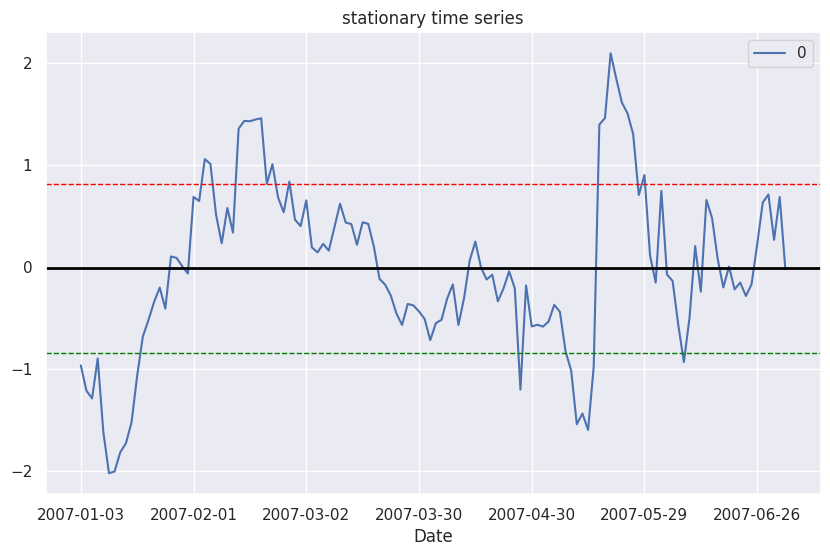

In [47]:


stationary_df.plot(grid=True, title=f'stationary time series', figsize=(10, 6))
stat_mean = stationary_df.mean()[0]
stat_sd = stationary_df.std()[0]
plt.axhline(y=stat_mean, color='black', linewidth=2)
plt.axhline(y=stat_mean + stat_sd, color='red', linewidth=1, linestyle='--')
plt.axhline(y=stat_mean - stat_sd, color='green', linewidth=1, linestyle='--')



<h2>
References
</h2>
<ol>
<li>
<i>Pairs Trading: Quantitative Method and Analysis</i> by Ganapathy Vidyamurthy, 2004, Wiley Publishing
</li>
<li>
Algorithmic Trading: Winning Strategies and Their Rationale by Ernie Chan, 2013, Wiley Publishing
</li>
<li>
<a href="https://medium.com/@financialnoob/granger-causality-test-in-pairs-trading-bf2fd939e575">Granger causality test in pairs trading</a> by
Alexander Pavlov (behind the Medium paywall)
</li>
<li>
<a href="https://letianzj.github.io/cointegration-pairs-trading.html">Quantitative Trading and Systematic Investing by Letian Wang</a> This
post includes a discussion on how the results of Johansen cointegration can be interpreted.
</li>
<li>
<a href="https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb.html">Introduction to Pairs Trading</a> by Delaney Mackenzie and Maxwell Margenot
</li>
<li>
<p>
<a href="https://quantdevel.com/pdf/betterHedgeRatios.pdf">Better Hedge Ratios for Spread Trading</a>, by Paul Teetor, November 2011
</p>
<p>
This note discusses the problem of using ordinary least squares to produce a hedge ratio.
</p>
</li>
<li>
<a href="http://jonathankinlay.com/2019/02/pairs-trading-part-2-practical-considerations/">Pairs Trading – Part 2: Practical Considerations</a> by Jonathan Kinlay
</li>
<li>
<a href="https://www.quantconnect.com/tutorials/strategy-library/intraday-dynamic-pairs-trading-using-correlation-and-cointegration-approach">Intraday Dynamic Pairs Trading using Correlation and Cointegration</a>
</li>
<li>
<a href="https://bsic.it/pairs-trading-building-a-backtesting-environment-with-python/">Pairs Trading: building a backtesting environment with Python</a>
</li>
<li>
<a href="https://www.sciencedirect.com/science/article/pii/S037843712100964X">Applying Hurst Exponent in pair trading strategies
on Nasdaq 100 index</a>
by Quynh Bui and Robert Ślepaczuk
</li>
<li>
<a href="https://www.sciencedirect.com/science/article/pii/S2214845021000880">Pairs trading: is it applicable to exchange-traded funds?</a>
</li>
<li>
<a href="https://hudsonthames.org/an-introduction-to-cointegration/">An Introduction to Cointegration for Pairs Trading By Yefeng Wang</a>
</li>
<li>
<a href="https://www.tradelikeamachine.com/blog/cointegration-pairs-trading/part-1-using-cointegration-for-a-pairs-trading-strategy"><i>Using Cointegration for a Pairs Trading Strategy</i> Martyn Tinsley</a>
</li>
<li>
<a href="https://www.inf.ovgu.de/inf_media/downloads/forschung/technical_reports_und_preprints/2014/02_2014.pdf">Cointegration Analysis
of Financial Time Series Data by Johannes Steffen, Pascal Held and Rudolf Kruse, 2014</a>
<li>
<a href="https://robotwealth.com/practical-pairs-trading/">Pairs Trading on the Robot Wealth blog by Kris Longmore</a>
</li>
</ol>